**LOAD DATA**

In [51]:
#install.packages("tidyverse")

In [52]:
#data<-read.csv("../input/train.csv")
#data<-read.csv("../input/train.csv")
#train = read.csv("../train.csv")
#dir()
#list.files(path = "../input")
#train<-read.table(file = train.csv)
library(tibble)
library(tidyverse)


In [53]:
library(tibble)
library(data.table)
train <- as_tibble(fread(cmd = "unzip -p ../input/nyc-taxi-trip-duration/train.zip"))


In [54]:
test <- as_tibble(fread(cmd = "unzip -p ../input/nyc-taxi-trip-duration/test.zip"))


In [55]:
#merge both test and train datasets
test$trip_duration<-NA
test$dropoff_datetime<-NA
data<-rbind(train,test)
rownumber<-nrow(train)

In [56]:
min.long<-min(data$pickup_longitude)
max.long<-max(data$pickup_longitude)
min.lat<-min(data$pickup_latitude)
max.lat<-max(data$pickup_latitude)
rm(test,train)

# ****Features and exploratory data analysis****

**1. General information about dataset**

In [57]:
head(data)
dim(data)

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.97903,40.76394,-74.00533,40.71009,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01004,40.71997,-74.01227,40.70672,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97305,40.79321,-73.97292,40.78252,N,435
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.98286,40.74220,-73.99208,40.74918,N,443


[1] 2083778      11

In [58]:
names(data)

[1] "id"                 "vendor_id"          "pickup_datetime"   
 [4] "dropoff_datetime"   "passenger_count"    "pickup_longitude"  
 [7] "pickup_latitude"    "dropoff_longitude"  "dropoff_latitude"  
[10] "store_and_fwd_flag" "trip_duration"

In [59]:
t1<-min(as.Date(data$pickup_datetime))
t2<-max(as.Date(data$pickup_datetime))
print(paste0("dates from ", t1, " to ", t2))
rm(t1,t2)

[1] "dates from 2016-01-01 to 2016-06-30"


**2. Vendor**
Taxi service provider in NYC

1       2 
 969102 1114676

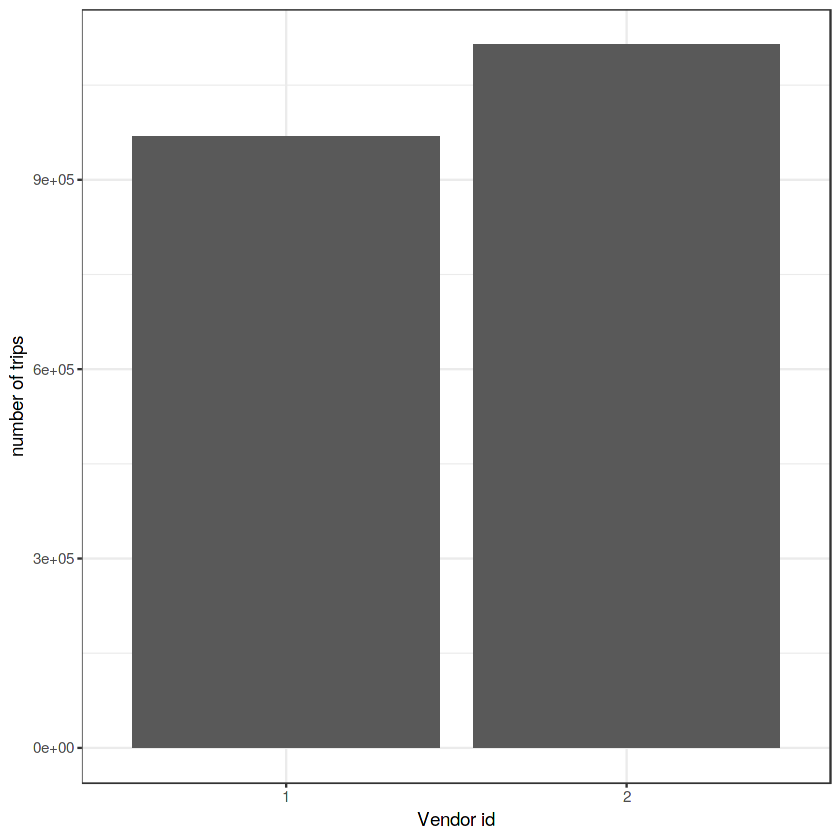

In [60]:
library(ggplot2)

ggplot(data,aes(x=as.factor(vendor_id)))+geom_bar()+theme_bw()+ ylab("number of trips")+xlab("Vendor id")

summary(as.factor(data$vendor_id))

**3. Date and time**

dropoff time and date is unknown in the testing data: prefer not to use (all the information used cannot be used as a predictor.

I separate the information provided into year, month, day, day of the week, hours and minutes. I also created the parameter "part.of.day" which indicates the part of the day when the trip took place. The ranges I used are:

* Morning (7 h): 5:00 - 11:59 
* Afternoon (5 h): 12:00 - 16:59 
* Evening (4 h): 17:00 - 20:59 
* Night (7 h): 21:00 - 4:59 

In [61]:
library(lubridate)
data$year<- lubridate::year(data$pickup_datetime) 
data$month<- lubridate::month(data$pickup_datetime) 
data$day <- lubridate::day(data$pickup_datetime)
data$wday <- lubridate::wday (data$pickup_datetime)
data$hour <- lubridate::hour(data$pickup_datetime)
data$minutes <-lubridate::minute(data$pickup_datetime)

In [62]:
data$part.of.day<-ifelse(data$hour<5,"night",ifelse(data$hour<12,"morning",ifelse(data$hour<17,"afternoon",ifelse(data$hour<21,"evening",ifelse(data$hour<24,"night",NA)))))


In [63]:
names(data)
head(data)

[1] "id"                 "vendor_id"          "pickup_datetime"   
 [4] "dropoff_datetime"   "passenger_count"    "pickup_longitude"  
 [7] "pickup_latitude"    "dropoff_longitude"  "dropoff_latitude"  
[10] "store_and_fwd_flag" "trip_duration"      "year"              
[13] "month"              "day"                "wday"              
[16] "hour"               "minutes"            "part.of.day"

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,wday,hour,minutes,part.of.day
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455,2016,3,14,2,17,24,evening
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663,2016,6,12,1,0,43,night
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.97903,40.76394,-74.00533,40.71009,N,2124,2016,1,19,3,11,35,morning
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01004,40.71997,-74.01227,40.70672,N,429,2016,4,6,4,19,32,evening
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97305,40.79321,-73.97292,40.78252,N,435,2016,3,26,7,13,30,afternoon
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.98286,40.74220,-73.99208,40.74918,N,443,2016,1,30,7,22,1,night


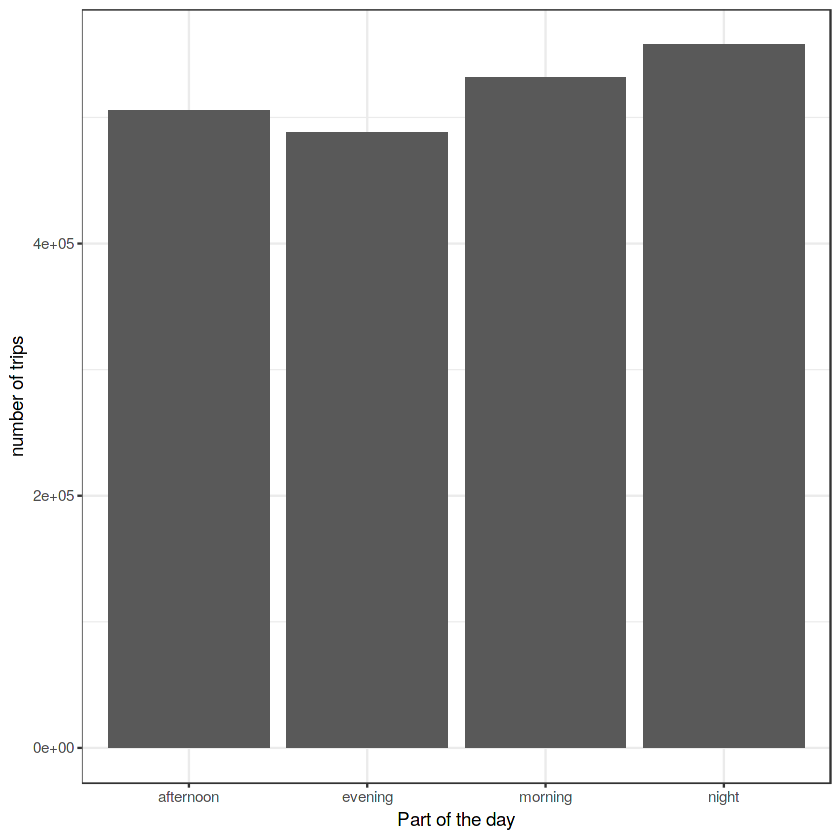

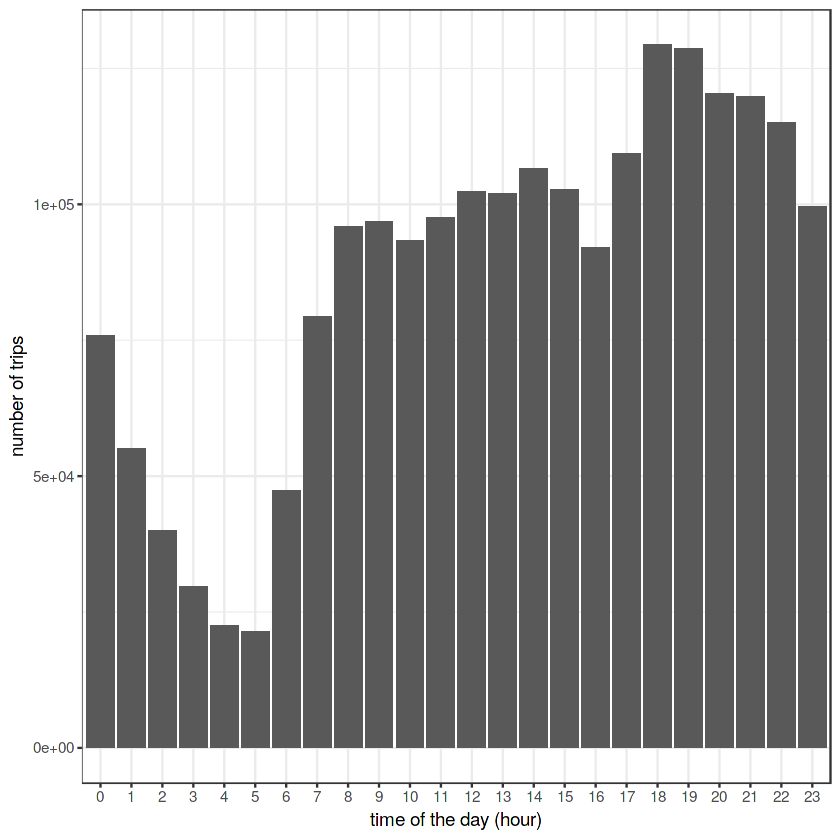

In [64]:
#plots

library(ggplot2)
ggplot(data,aes(x=as.factor(part.of.day)))+geom_bar()+theme_bw()+ ylab("number of trips")+xlab("Part of the day")
ggplot(data,aes(x=as.factor(hour)))+geom_bar()+theme_bw()+ ylab("number of trips")+xlab("time of the day (hour)")



Most of the trips take place during the night, however, the peak occurs in the evening (18-19 h).

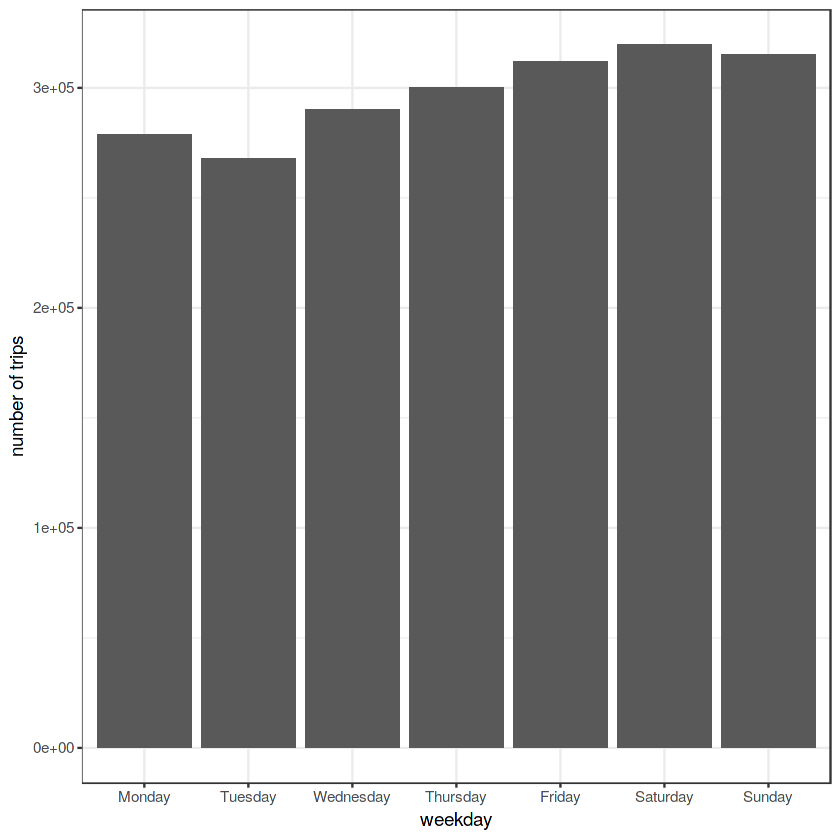

In [65]:
data$wday<-as.factor(data$wday)
levels(data$wday) <-c("Monday", "Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday")
#1 means Monday, 7 means Sunday (default)
ggplot(data,aes(x=wday))+geom_bar()+theme_bw()+ ylab("number of trips")+xlab("weekday")

**4. Passenger count**

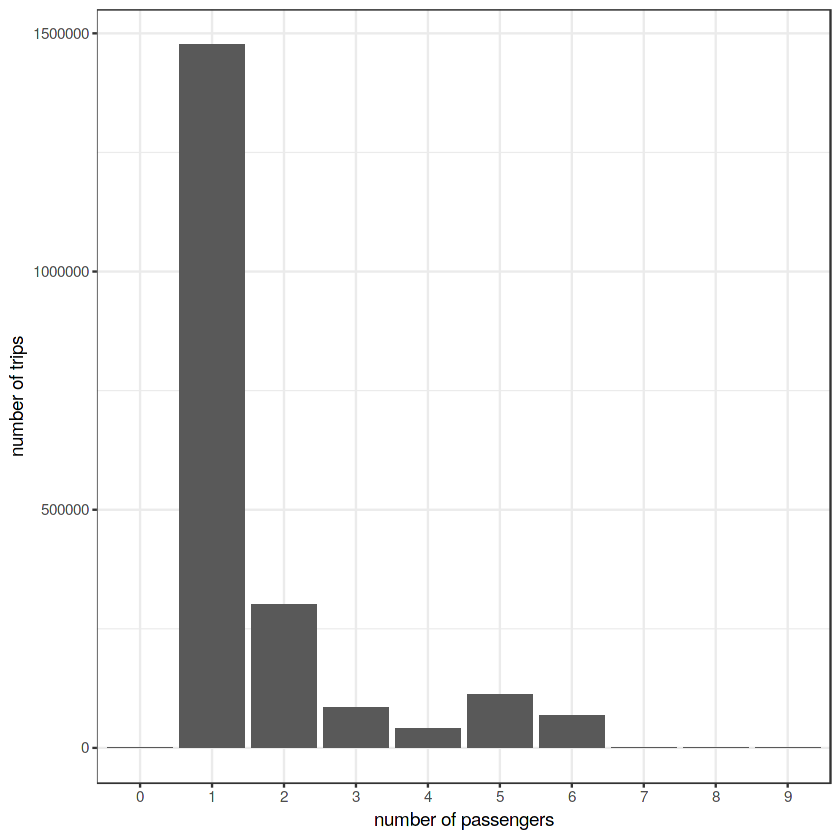

In [66]:
ggplot(data,aes(x=as.factor(passenger_count)))+geom_bar()+theme_bw()+ ylab("number of trips")+xlab("number of passengers")

Most of the trips are done with one passenger. For more than 4 passengers it is assumed the car has to be big, so I create a new variable. I assume all trips with less than 4 passengers are done in smaller taxis.

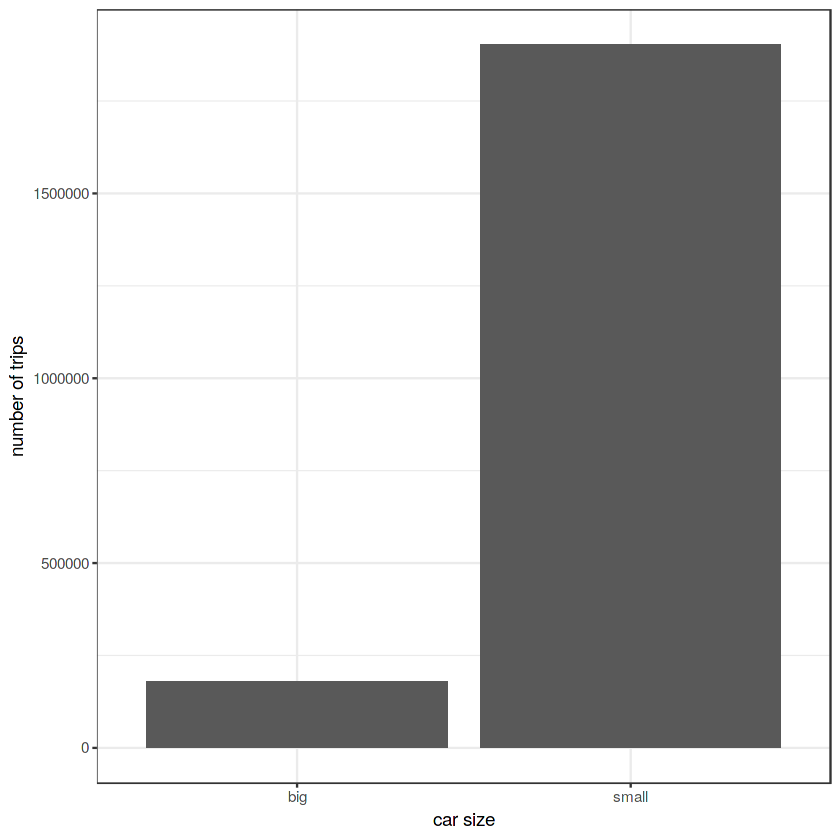

In [67]:
data$car.size<-ifelse(data$passenger_count>4,"big","small")
ggplot(data,aes(x=car.size))+geom_bar()+theme_bw()+ ylab("number of trips")+xlab("car size")

In [68]:
names(data)

[1] "id"                 "vendor_id"          "pickup_datetime"   
 [4] "dropoff_datetime"   "passenger_count"    "pickup_longitude"  
 [7] "pickup_latitude"    "dropoff_longitude"  "dropoff_latitude"  
[10] "store_and_fwd_flag" "trip_duration"      "year"              
[13] "month"              "day"                "wday"              
[16] "hour"               "minutes"            "part.of.day"       
[19] "car.size"

5. Pick-up and drop-off location

In [69]:
library(tidyr)
library(dplyr)
library(ggplot2)

subdata1<-data%>%group_by(round(pickup_latitude,2),round(pickup_longitude,2))%>%count(n=n())
names(subdata1)<-c("latitude","longitude","n","nn")
subdata1$nn<-NULL
names(subdata1)<-c("latitude","longitude","trip.number")


Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.



Warning message:
“Removed 320 rows containing missing values (geom_tile).”


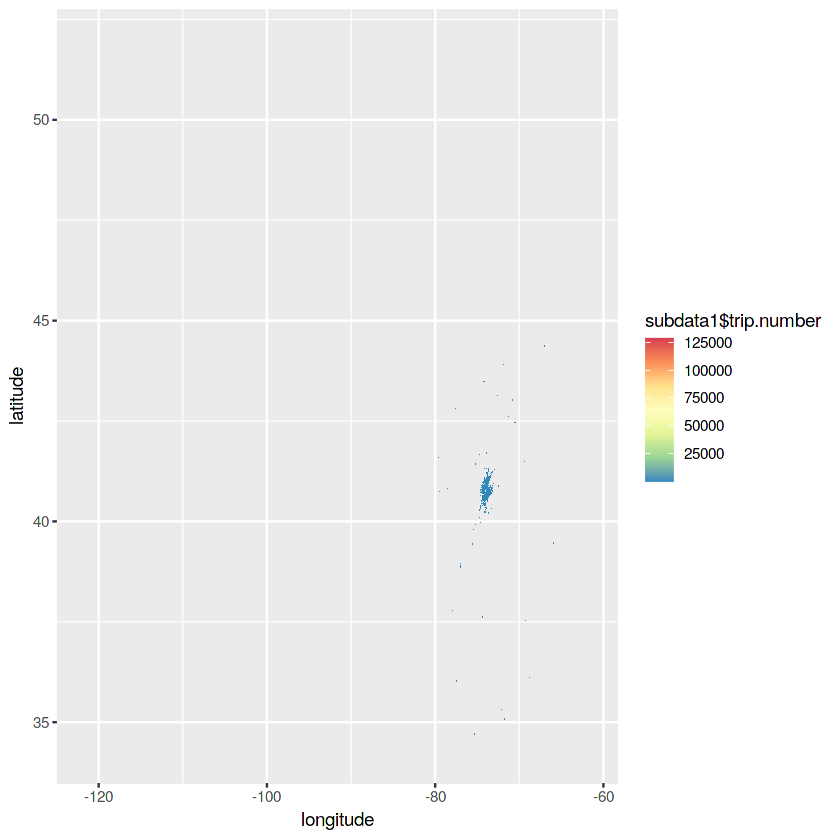

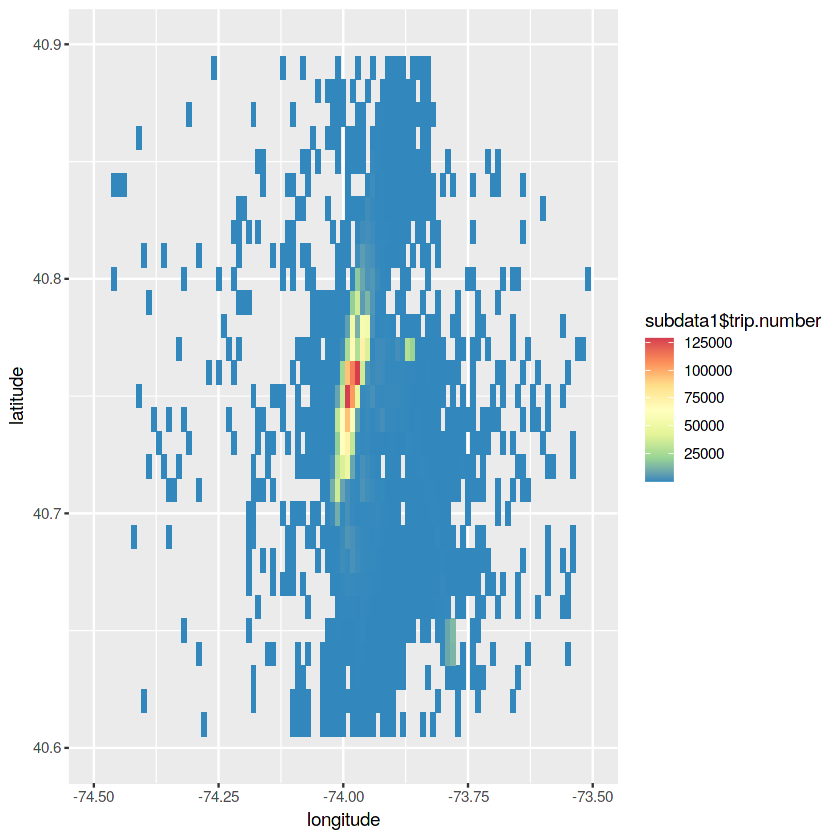

In [70]:
#cuadrantes con número de viajes: del total del periodo: después ver tasa de viajes por año, día, etc
ggplot(subdata1,aes(y=latitude,x=longitude,fill=subdata1$trip.number))+geom_tile()+
  scale_fill_distiller(palette = "Spectral")+xlim(min.long,max.long)+ylim(min.lat,max.lat)

#zoomed-in
#min.long
#max.long
#min.lat
#max.lat
ggplot(subdata1,aes(y=latitude,x=longitude,fill=subdata1$trip.number))+geom_tile()+
  scale_fill_distiller(palette = "Spectral")+xlim(-74.5,-73.5)+ylim(40.6,40.9)

# **Adding new variables**


7. Movement direction: North, south, east or west.

In [71]:
data<-mutate(data,delta.latitude=(dropoff_latitude-pickup_latitude))
data<-mutate(data,delta.longitude=(dropoff_longitude-pickup_longitude))

data$delta.latitude<-ifelse(data$delta.latitude==0,NA,data$delta.latitude)
data$delta.longitude<-ifelse(data$delta.longitude==0,NA,data$delta.longitude)
data$NS.movement<-ifelse(data$delta.latitude>0,"North","South")
data$EW.movement<-ifelse(data$delta.longitude>0,"East","West")
data$mov.direction <- paste(data$NS.movement,data$EW.movement)


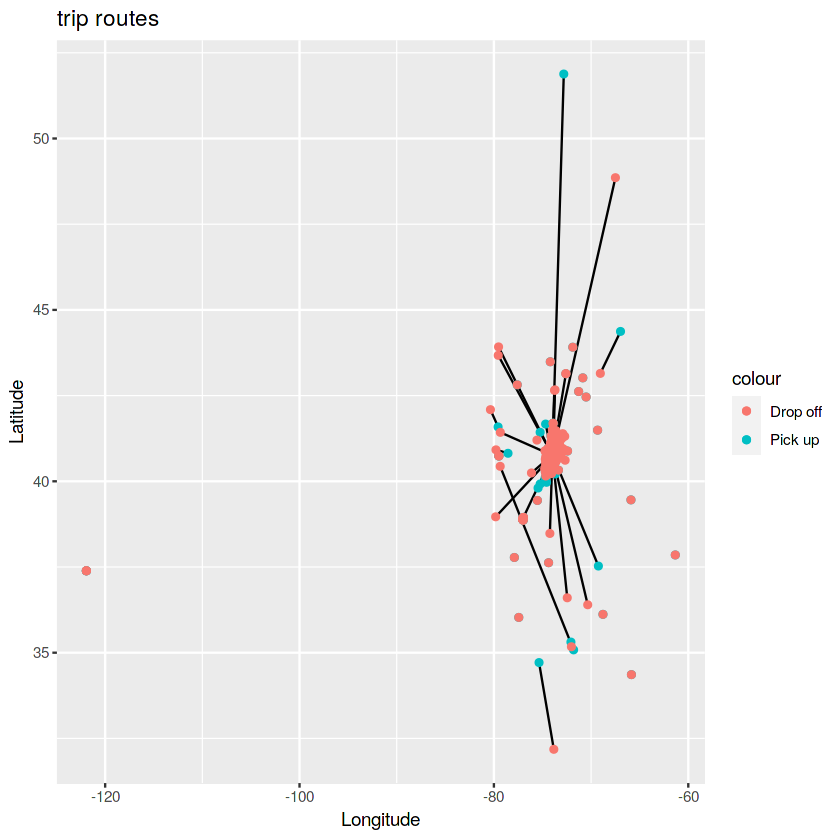

In [72]:
ggplot(data)+
  geom_segment(aes(x=pickup_longitude,y=pickup_latitude, 
                   xend = dropoff_longitude,yend = dropoff_latitude))+
  geom_point(aes(x=pickup_longitude,y=pickup_latitude,colour="Pick up"))+
  geom_point(aes(x=dropoff_longitude,y=dropoff_latitude,colour="Drop off"))+
labs(title = "trip routes", x = "Longitude", y = "Latitude")

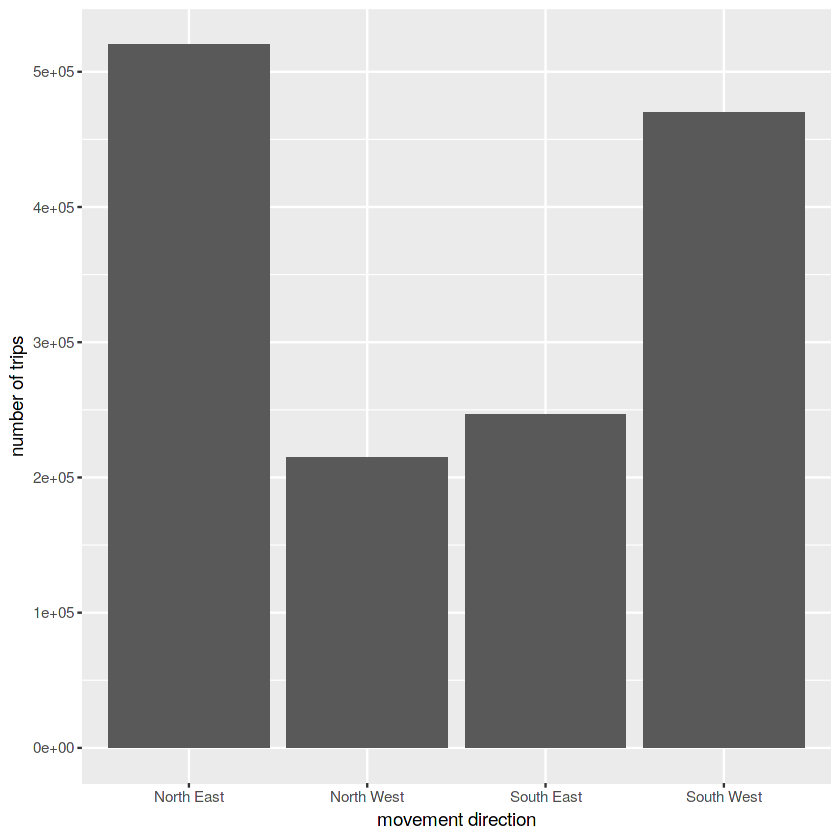

In [73]:
data2<-na.omit(data)
ggplot(data2,aes(x=mov.direction))+geom_bar()+ ylab("number of trips")+xlab("movement direction")
rm(data2)

6. Distance and speed
I calculate the movement from pick up to drop off. The speed is calculated from the distance value.


In [83]:
head(data)
data$delta.latitude<-ifelse(data$delta.latitude==0,NA,data$delta.latitude)
data$delta.longitude<-ifelse(data$delta.longitude==0,NA,data$delta.longitude)

#install.packages("gmt")
library(gmt)

data$distance<- geodist(data$pickup_latitude,data$pickup_longitude,data$dropoff_latitude,data$dropoff_longitude,units="km")
data$speed<-data$distance*3600/data$trip_duration # km/s --> km/h
  

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,⋯,minutes,part.of.day,car.size,delta.latitude,delta.longitude,NS.movement,EW.movement,mov.direction,distance,speed
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,⋯,24,evening,small,-0.002334595,0.0175247192,South,East,South East,1.497511,11.848439
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,⋯,43,night,small,-0.007411957,-0.0190658569,South,West,South West,1.804291,9.797053
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.97903,40.76394,-74.00533,40.71009,N,⋯,35,morning,small,-0.053852081,-0.0263061523,South,West,South West,6.380796,10.814908
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01004,40.71997,-74.01227,40.70672,N,⋯,32,evening,small,-0.013252258,-0.0022277832,South,West,South West,1.484497,12.457321
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97305,40.79321,-73.97292,40.78252,N,⋯,30,afternoon,small,-0.010688782,0.0001296997,South,East,South East,1.187788,9.829966
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.98286,40.74220,-73.99208,40.74918,N,⋯,1,night,big,0.006988525,-0.0092239380,North,West,North West,1.098202,8.924440


Warning message in acos(sin(N1) * sin(N2) + cos(N1) * cos(N2) * cos(E1 - E2)):
“NaNs produced”


In [75]:
#mean distance vs. day of the week
data$distance[data$distance=="NaN"]<-NA
subdata5<-na.omit(data)
subdata5<-subdata5%>%group_by(wday)%>%summarise(n=mean(distance))
subdata5
rm(subdata5)

`summarise()` ungrouping output (override with `.groups` argument)



wday,n
<fct>,<dbl>
Monday,3.734014
Tuesday,3.580964
Wednesday,3.359019
Thursday,3.358521
Friday,3.435115
Saturday,3.408179
Sunday,3.347215


In [76]:
#mean distance vs. part of the day
subdata6<-na.omit(data)
subdata6<-subdata6%>%group_by(part.of.day)%>%summarise(n=mean(distance)) 
subdata6
rm(subdata6)

`summarise()` ungrouping output (override with `.groups` argument)



part.of.day,n
<chr>,<dbl>
afternoon,3.338903
evening,3.258489
morning,3.270261
night,3.907182


In [77]:
#mean distance vs. vendor id
subdata7<-na.omit(data)
subdata7<-subdata7%>%group_by(vendor_id)%>%summarise(n=mean(distance))
subdata7
rm(subdata7)

`summarise()` ungrouping output (override with `.groups` argument)



vendor_id,n
<int>,<dbl>
1,3.415626
2,3.488949


In [78]:
#mean distance vs. month
subdata8<-na.omit(data)
subdata8<-subdata8%>%group_by(month)%>%summarise(n=mean(distance))
subdata8
rm(subdata8)

`summarise()` ungrouping output (override with `.groups` argument)



month,n
<dbl>,<dbl>
1,3.391773
2,3.340148
3,3.443638
4,3.448565
5,3.565343
6,3.535074


`summarise()` ungrouping output (override with `.groups` argument)



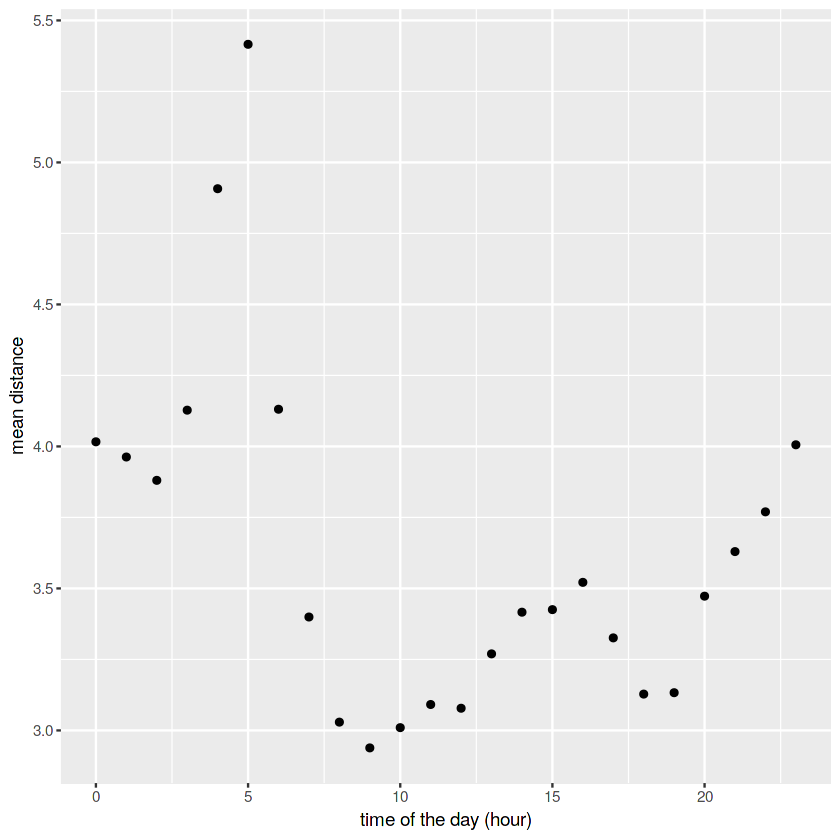

In [79]:
#mean distance vs. time (hour)
subdata9<-na.omit(data)
subdata9<-subdata9%>%group_by(hour)%>%summarise(n=mean(distance))
ggplot(subdata9,aes(x=hour,y=n))+geom_point()+ ylab("mean distance")+xlab("time of the day (hour)")
rm(subdata9)

In [80]:

#mean distance vs. car size
subdata10<-na.omit(data)
subdata10<-subdata10%>%group_by(car.size)%>%summarise(n=mean(distance))
subdata10
rm(subdata10)

`summarise()` ungrouping output (override with `.groups` argument)



car.size,n
<chr>,<dbl>
big,3.485196
small,3.451951


In [81]:
#mean distance vs. number of passengers
subdata11<-na.omit(data)
subdata11<-subdata11%>%group_by(passenger_count)%>%summarise(n=mean(distance))
subdata11
rm(subdata11)

`summarise()` ungrouping output (override with `.groups` argument)



passenger_count,n
<int>,<dbl>
0,1.590624907
1,3.397880984
2,3.666183397
3,3.539958294
4,3.649961846
5,3.526214103
6,3.418819543
7,0.002624011
8,5.947841969


In [82]:
# mean distance vs.  direction
subdata12<-na.omit(data)
subdata12<-subdata12%>%group_by(mov.direction)%>%summarise(n=mean(distance)) 
subdata12
rm(subdata12)

`summarise()` ungrouping output (override with `.groups` argument)



mov.direction,n
<chr>,<dbl>
North East,3.271472
North West,4.137403
South East,3.613893
South West,3.261896
